In [1]:
#Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

C:\Users\annek\AppData\Local\Temp\ipykernel_11336\3843223860.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


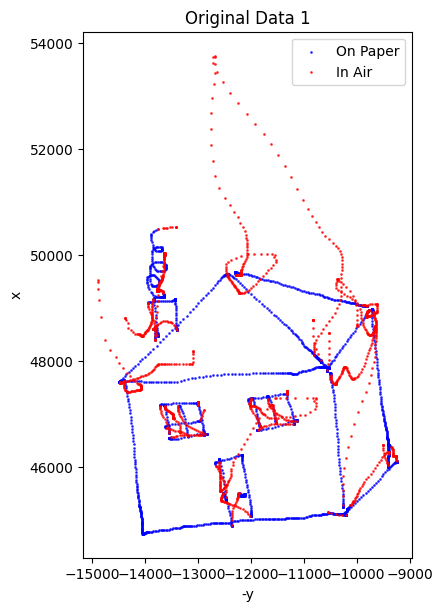

Processed data shape: (3332, 4)
Average number of data points: 3332


In [3]:
#Cell 2
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Adjust timestamp to start from 0
        df['timestamp'] = df['timestamp'] - df['timestamp'].min()
        
        df = df.iloc[:, [0, 1, 2, 3]]  # Select x, y, timestamp, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points

# Update the call to the function
directory = 'Task2'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=1)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")

In [4]:
# Cell 3 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),  # Changed from 3 to 4
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)  # Changed from 3 to 4
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_time = tf.sigmoid(decoded[:, :3])  # Apply sigmoid to x, y, and timestamp
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_time, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# Update the compute_loss function
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_time = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_time + reconstruction_loss_pen, kl_loss, model.beta * kl_loss

# Update the VAE instantiation
latent_dim = 256
beta = 0.001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)

C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100:   0%|          | 0/7 [00:00<?, ?batch/s]

Epoch 1/100: 100%|██████████| 7/7 [00:07<00:00,  1.06s/batch, Total Loss=0.803, Reconstruction Loss=0.803, KL Loss=0.000458]


Epoch 1: Total Loss = 0.795019, Reconstruction Loss = 0.795018, KL Divergence Loss = 0.000317
MAE = 0.213636, MSE = 0.064730, NRMSE = 0.254421


Epoch 2/100: 100%|██████████| 7/7 [00:00<00:00, 46.71batch/s, Total Loss=0.743, Reconstruction Loss=0.743, KL Loss=0.00115] 


Epoch 2: Total Loss = 0.752811, Reconstruction Loss = 0.752810, KL Divergence Loss = 0.000820
MAE = 0.206449, MSE = 0.061709, NRMSE = 0.248412


Epoch 3/100: 100%|██████████| 7/7 [00:00<00:00, 21.89batch/s, Total Loss=0.726, Reconstruction Loss=0.726, KL Loss=0.00345]


Epoch 3: Total Loss = 0.731422, Reconstruction Loss = 0.731419, KL Divergence Loss = 0.002342
MAE = 0.207196, MSE = 0.061825, NRMSE = 0.248647


Epoch 4/100: 100%|██████████| 7/7 [00:00<00:00, 49.78batch/s, Total Loss=0.591, Reconstruction Loss=0.591, KL Loss=0.0132] 


Epoch 4: Total Loss = 0.653136, Reconstruction Loss = 0.653128, KL Divergence Loss = 0.008148
MAE = 0.206833, MSE = 0.060774, NRMSE = 0.246523


Epoch 5/100: 100%|██████████| 7/7 [00:00<00:00, 40.73batch/s, Total Loss=0.335, Reconstruction Loss=0.335, KL Loss=0.0398]


Epoch 5: Total Loss = 0.444030, Reconstruction Loss = 0.444003, KL Divergence Loss = 0.027467
MAE = 0.207701, MSE = 0.060799, NRMSE = 0.246574


Epoch 6/100: 100%|██████████| 7/7 [00:00<00:00, 40.73batch/s, Total Loss=0.0979, Reconstruction Loss=0.0978, KL Loss=0.0983]


Epoch 6: Total Loss = 0.170150, Reconstruction Loss = 0.170077, KL Divergence Loss = 0.072797
MAE = 0.209644, MSE = 0.062021, NRMSE = 0.249039


Epoch 7/100: 100%|██████████| 7/7 [00:00<00:00, 44.80batch/s, Total Loss=0.0711, Reconstruction Loss=0.0709, KL Loss=0.143]


Epoch 7: Total Loss = 0.078651, Reconstruction Loss = 0.078519, KL Divergence Loss = 0.131637
MAE = 0.211677, MSE = 0.064035, NRMSE = 0.253052


Epoch 8/100: 100%|██████████| 7/7 [00:00<00:00, 34.41batch/s, Total Loss=0.0691, Reconstruction Loss=0.0688, KL Loss=0.217]


Epoch 8: Total Loss = 0.069626, Reconstruction Loss = 0.069435, KL Divergence Loss = 0.191428
MAE = 0.223376, MSE = 0.070385, NRMSE = 0.265302


Epoch 9/100: 100%|██████████| 7/7 [00:00<00:00, 44.80batch/s, Total Loss=0.0648, Reconstruction Loss=0.0645, KL Loss=0.231]


Epoch 9: Total Loss = 0.066820, Reconstruction Loss = 0.066599, KL Divergence Loss = 0.221141
MAE = 0.218514, MSE = 0.067407, NRMSE = 0.259629


Epoch 10/100: 100%|██████████| 7/7 [00:00<00:00, 26.35batch/s, Total Loss=0.0587, Reconstruction Loss=0.0585, KL Loss=0.248]


Epoch 10: Total Loss = 0.063292, Reconstruction Loss = 0.063059, KL Divergence Loss = 0.233292
MAE = 0.223476, MSE = 0.070150, NRMSE = 0.264859


Epoch 11/100: 100%|██████████| 7/7 [00:00<00:00, 40.63batch/s, Total Loss=0.0624, Reconstruction Loss=0.0621, KL Loss=0.26] 


Epoch 11: Total Loss = 0.061140, Reconstruction Loss = 0.060889, KL Divergence Loss = 0.251566
MAE = 0.221471, MSE = 0.068782, NRMSE = 0.262263


Epoch 12/100: 100%|██████████| 7/7 [00:00<00:00, 49.78batch/s, Total Loss=0.0546, Reconstruction Loss=0.0543, KL Loss=0.289]

Epoch 12: Total Loss = 0.057751, Reconstruction Loss = 0.057467, KL Divergence Loss = 0.284157


MAE = 0.221514, MSE = 0.068700, NRMSE = 0.262107


Epoch 13/100: 100%|██████████| 7/7 [00:00<00:00, 34.46batch/s, Total Loss=0.0517, Reconstruction Loss=0.0514, KL Loss=0.281]


Epoch 13: Total Loss = 0.053062, Reconstruction Loss = 0.052772, KL Divergence Loss = 0.289654
MAE = 0.222824, MSE = 0.069620, NRMSE = 0.263855


Epoch 14/100: 100%|██████████| 7/7 [00:00<00:00, 44.72batch/s, Total Loss=0.046, Reconstruction Loss=0.0457, KL Loss=0.361] 


Epoch 14: Total Loss = 0.048759, Reconstruction Loss = 0.048426, KL Divergence Loss = 0.333360
MAE = 0.225629, MSE = 0.071073, NRMSE = 0.266595


Epoch 15/100: 100%|██████████| 7/7 [00:00<00:00, 37.33batch/s, Total Loss=0.0433, Reconstruction Loss=0.0429, KL Loss=0.406]


Epoch 15: Total Loss = 0.045407, Reconstruction Loss = 0.045023, KL Divergence Loss = 0.384689
MAE = 0.225869, MSE = 0.071775, NRMSE = 0.267909


Epoch 16/100: 100%|██████████| 7/7 [00:00<00:00, 44.80batch/s, Total Loss=0.0421, Reconstruction Loss=0.0417, KL Loss=0.417]


Epoch 16: Total Loss = 0.043305, Reconstruction Loss = 0.042894, KL Divergence Loss = 0.411099
MAE = 0.230665, MSE = 0.075140, NRMSE = 0.274116


Epoch 17/100: 100%|██████████| 7/7 [00:00<00:00, 55.99batch/s, Total Loss=0.039, Reconstruction Loss=0.0385, KL Loss=0.457] 


Epoch 17: Total Loss = 0.041072, Reconstruction Loss = 0.040642, KL Divergence Loss = 0.430761
MAE = 0.231953, MSE = 0.076326, NRMSE = 0.276272


Epoch 18/100: 100%|██████████| 7/7 [00:00<00:00, 29.87batch/s, Total Loss=0.04, Reconstruction Loss=0.0395, KL Loss=0.451]  


Epoch 18: Total Loss = 0.039238, Reconstruction Loss = 0.038788, KL Divergence Loss = 0.450288
MAE = 0.234087, MSE = 0.078438, NRMSE = 0.280068


Epoch 19/100: 100%|██████████| 7/7 [00:00<00:00, 44.80batch/s, Total Loss=0.0372, Reconstruction Loss=0.0367, KL Loss=0.48] 


Epoch 19: Total Loss = 0.036766, Reconstruction Loss = 0.036289, KL Divergence Loss = 0.477459
MAE = 0.236403, MSE = 0.081324, NRMSE = 0.285174


Epoch 20/100: 100%|██████████| 7/7 [00:00<00:00, 31.94batch/s, Total Loss=0.0311, Reconstruction Loss=0.0306, KL Loss=0.518]


Epoch 20: Total Loss = 0.034241, Reconstruction Loss = 0.033735, KL Divergence Loss = 0.505364
MAE = 0.238815, MSE = 0.083741, NRMSE = 0.289381


Epoch 21/100: 100%|██████████| 7/7 [00:00<00:00, 37.33batch/s, Total Loss=0.0328, Reconstruction Loss=0.0322, KL Loss=0.548]


Epoch 21: Total Loss = 0.032825, Reconstruction Loss = 0.032293, KL Divergence Loss = 0.531763
MAE = 0.239468, MSE = 0.085428, NRMSE = 0.292280


Epoch 22/100: 100%|██████████| 7/7 [00:00<00:00, 49.78batch/s, Total Loss=0.0295, Reconstruction Loss=0.0289, KL Loss=0.553]


Epoch 22: Total Loss = 0.031453, Reconstruction Loss = 0.030898, KL Divergence Loss = 0.554964
MAE = 0.243962, MSE = 0.089720, NRMSE = 0.299534


Epoch 23/100: 100%|██████████| 7/7 [00:00<00:00, 40.73batch/s, Total Loss=0.0288, Reconstruction Loss=0.0282, KL Loss=0.608]


Epoch 23: Total Loss = 0.030587, Reconstruction Loss = 0.030000, KL Divergence Loss = 0.587003
MAE = 0.246368, MSE = 0.092644, NRMSE = 0.304374


Epoch 24/100: 100%|██████████| 7/7 [00:00<00:00, 44.80batch/s, Total Loss=0.0295, Reconstruction Loss=0.0288, KL Loss=0.623]

Epoch 24: Total Loss = 0.029926, Reconstruction Loss = 0.029313, KL Divergence Loss = 0.613253


MAE = 0.248207, MSE = 0.094650, NRMSE = 0.307653


Epoch 25/100: 100%|██████████| 7/7 [00:00<00:00, 40.73batch/s, Total Loss=0.0266, Reconstruction Loss=0.0259, KL Loss=0.688]


Epoch 25: Total Loss = 0.028767, Reconstruction Loss = 0.028117, KL Divergence Loss = 0.650743
MAE = 0.246257, MSE = 0.093730, NRMSE = 0.306153


Epoch 26/100: 100%|██████████| 7/7 [00:00<00:00, 49.61batch/s, Total Loss=0.0256, Reconstruction Loss=0.0249, KL Loss=0.7]  


Epoch 26: Total Loss = 0.027879, Reconstruction Loss = 0.027192, KL Divergence Loss = 0.687208
MAE = 0.246300, MSE = 0.094280, NRMSE = 0.307050


Epoch 27/100: 100%|██████████| 7/7 [00:00<00:00, 40.73batch/s, Total Loss=0.0272, Reconstruction Loss=0.0264, KL Loss=0.747]


Epoch 27: Total Loss = 0.027155, Reconstruction Loss = 0.026424, KL Divergence Loss = 0.730380
MAE = 0.245564, MSE = 0.094775, NRMSE = 0.307855


Epoch 28/100: 100%|██████████| 7/7 [00:00<00:00, 37.33batch/s, Total Loss=0.024, Reconstruction Loss=0.0231, KL Loss=0.813] 


Epoch 28: Total Loss = 0.026049, Reconstruction Loss = 0.025269, KL Divergence Loss = 0.779853
MAE = 0.247563, MSE = 0.096693, NRMSE = 0.310956


Epoch 29/100: 100%|██████████| 7/7 [00:00<00:00, 40.40batch/s, Total Loss=0.0236, Reconstruction Loss=0.0228, KL Loss=0.854]


Epoch 29: Total Loss = 0.024596, Reconstruction Loss = 0.023772, KL Divergence Loss = 0.823895
MAE = 0.244884, MSE = 0.094940, NRMSE = 0.308124


Epoch 30/100: 100%|██████████| 7/7 [00:00<00:00, 44.80batch/s, Total Loss=0.0218, Reconstruction Loss=0.0209, KL Loss=0.867]


Epoch 30: Total Loss = 0.023364, Reconstruction Loss = 0.022503, KL Divergence Loss = 0.861066
MAE = 0.246720, MSE = 0.097830, NRMSE = 0.312778


Epoch 31/100: 100%|██████████| 7/7 [00:00<00:00, 55.83batch/s, Total Loss=0.023, Reconstruction Loss=0.022, KL Loss=0.908]  


Epoch 31: Total Loss = 0.022104, Reconstruction Loss = 0.021208, KL Divergence Loss = 0.895989
MAE = 0.247380, MSE = 0.099597, NRMSE = 0.315590


Epoch 32/100: 100%|██████████| 7/7 [00:00<00:00, 40.71batch/s, Total Loss=0.0214, Reconstruction Loss=0.0204, KL Loss=0.971]


Epoch 32: Total Loss = 0.020857, Reconstruction Loss = 0.019917, KL Divergence Loss = 0.939229
MAE = 0.250190, MSE = 0.102611, NRMSE = 0.320330


Epoch 33/100: 100%|██████████| 7/7 [00:00<00:00, 56.00batch/s, Total Loss=0.0188, Reconstruction Loss=0.0178, KL Loss=1.03] 


Epoch 33: Total Loss = 0.019584, Reconstruction Loss = 0.018606, KL Divergence Loss = 0.977338
MAE = 0.250099, MSE = 0.103337, NRMSE = 0.321461


Epoch 34/100: 100%|██████████| 7/7 [00:00<00:00, 21.33batch/s, Total Loss=0.0188, Reconstruction Loss=0.0178, KL Loss=0.996]


Epoch 34: Total Loss = 0.019292, Reconstruction Loss = 0.018284, KL Divergence Loss = 1.008182
MAE = 0.250875, MSE = 0.105091, NRMSE = 0.324177


Epoch 35/100: 100%|██████████| 7/7 [00:00<00:00, 56.00batch/s, Total Loss=0.0185, Reconstruction Loss=0.0174, KL Loss=1.05]


Epoch 35: Total Loss = 0.018696, Reconstruction Loss = 0.017658, KL Divergence Loss = 1.037194
MAE = 0.252739, MSE = 0.106737, NRMSE = 0.326706


Epoch 36/100: 100%|██████████| 7/7 [00:00<00:00, 44.80batch/s, Total Loss=0.0168, Reconstruction Loss=0.0156, KL Loss=1.12]


Epoch 36: Total Loss = 0.017623, Reconstruction Loss = 0.016557, KL Divergence Loss = 1.066097
MAE = 0.255541, MSE = 0.109641, NRMSE = 0.331120


Epoch 37/100: 100%|██████████| 7/7 [00:00<00:00, 56.05batch/s, Total Loss=0.0173, Reconstruction Loss=0.0162, KL Loss=1.09]


Epoch 37: Total Loss = 0.017086, Reconstruction Loss = 0.015997, KL Divergence Loss = 1.088825
MAE = 0.256865, MSE = 0.111422, NRMSE = 0.333799


Epoch 38/100: 100%|██████████| 7/7 [00:00<00:00, 40.61batch/s, Total Loss=0.0163, Reconstruction Loss=0.0152, KL Loss=1.13]


Epoch 38: Total Loss = 0.016492, Reconstruction Loss = 0.015375, KL Divergence Loss = 1.117488
MAE = 0.258543, MSE = 0.113204, NRMSE = 0.336457


Epoch 39/100: 100%|██████████| 7/7 [00:00<00:00, 55.93batch/s, Total Loss=0.017, Reconstruction Loss=0.0158, KL Loss=1.14] 


Epoch 39: Total Loss = 0.015918, Reconstruction Loss = 0.014779, KL Divergence Loss = 1.138730
MAE = 0.258451, MSE = 0.113780, NRMSE = 0.337314


Epoch 40/100: 100%|██████████| 7/7 [00:00<00:00, 49.78batch/s, Total Loss=0.015, Reconstruction Loss=0.0138, KL Loss=1.14] 


Epoch 40: Total Loss = 0.015395, Reconstruction Loss = 0.014231, KL Divergence Loss = 1.163621
MAE = 0.258762, MSE = 0.114026, NRMSE = 0.337678


Epoch 41/100: 100%|██████████| 7/7 [00:00<00:00, 29.87batch/s, Total Loss=0.0127, Reconstruction Loss=0.0115, KL Loss=1.21]


Epoch 41: Total Loss = 0.014854, Reconstruction Loss = 0.013666, KL Divergence Loss = 1.188489
MAE = 0.261002, MSE = 0.116297, NRMSE = 0.341024


Epoch 42/100: 100%|██████████| 7/7 [00:00<00:00, 49.78batch/s, Total Loss=0.014, Reconstruction Loss=0.0128, KL Loss=1.2]  

Epoch 42: Total Loss = 0.014780, Reconstruction Loss = 0.013573, KL Divergence Loss = 1.206813


MAE = 0.262826, MSE = 0.118287, NRMSE = 0.343929


Epoch 43/100: 100%|██████████| 7/7 [00:00<00:00, 31.92batch/s, Total Loss=0.0143, Reconstruction Loss=0.0131, KL Loss=1.22]


Epoch 43: Total Loss = 0.014781, Reconstruction Loss = 0.013560, KL Divergence Loss = 1.220541
MAE = 0.263942, MSE = 0.119358, NRMSE = 0.345482


Epoch 44/100: 100%|██████████| 7/7 [00:00<00:00, 44.80batch/s, Total Loss=0.0134, Reconstruction Loss=0.0122, KL Loss=1.25]

Epoch 44: Total Loss = 0.014456, Reconstruction Loss = 0.013227, KL Divergence Loss = 1.229039


MAE = 0.266749, MSE = 0.121141, NRMSE = 0.348054


Epoch 45/100: 100%|██████████| 7/7 [00:00<00:00, 40.73batch/s, Total Loss=0.0141, Reconstruction Loss=0.0129, KL Loss=1.2] 


Epoch 45: Total Loss = 0.014112, Reconstruction Loss = 0.012880, KL Divergence Loss = 1.232713
MAE = 0.266875, MSE = 0.121931, NRMSE = 0.349186


Epoch 46/100: 100%|██████████| 7/7 [00:00<00:00, 44.80batch/s, Total Loss=0.0141, Reconstruction Loss=0.0129, KL Loss=1.21]


Epoch 46: Total Loss = 0.013844, Reconstruction Loss = 0.012603, KL Divergence Loss = 1.241559
MAE = 0.268627, MSE = 0.124448, NRMSE = 0.352772


Epoch 47/100: 100%|██████████| 7/7 [00:00<00:00, 44.80batch/s, Total Loss=0.0121, Reconstruction Loss=0.0108, KL Loss=1.25]


Epoch 47: Total Loss = 0.013049, Reconstruction Loss = 0.011799, KL Divergence Loss = 1.250138
MAE = 0.270052, MSE = 0.125026, NRMSE = 0.353591


Epoch 48/100: 100%|██████████| 7/7 [00:00<00:00, 34.46batch/s, Total Loss=0.0142, Reconstruction Loss=0.0128, KL Loss=1.35]


Epoch 48: Total Loss = 0.013278, Reconstruction Loss = 0.012012, KL Divergence Loss = 1.265565
MAE = 0.267757, MSE = 0.123341, NRMSE = 0.351199


Epoch 49/100: 100%|██████████| 7/7 [00:00<00:00, 49.73batch/s, Total Loss=0.0122, Reconstruction Loss=0.011, KL Loss=1.26] 

Epoch 49: Total Loss = 0.012973, Reconstruction Loss = 0.011707, KL Divergence Loss = 1.266137


MAE = 0.269182, MSE = 0.124655, NRMSE = 0.353066


Epoch 50/100: 100%|██████████| 7/7 [00:00<00:00, 40.73batch/s, Total Loss=0.0124, Reconstruction Loss=0.0112, KL Loss=1.24]


Epoch 50: Total Loss = 0.012817, Reconstruction Loss = 0.011544, KL Divergence Loss = 1.273485
MAE = 0.272179, MSE = 0.126686, NRMSE = 0.355930


Epoch 51/100: 100%|██████████| 7/7 [00:00<00:00, 49.78batch/s, Total Loss=0.0123, Reconstruction Loss=0.011, KL Loss=1.25] 


Epoch 51: Total Loss = 0.012451, Reconstruction Loss = 0.011170, KL Divergence Loss = 1.281436
MAE = 0.271975, MSE = 0.127856, NRMSE = 0.357570


Epoch 52/100: 100%|██████████| 7/7 [00:00<00:00, 56.00batch/s, Total Loss=0.0117, Reconstruction Loss=0.0104, KL Loss=1.26]


Epoch 52: Total Loss = 0.012107, Reconstruction Loss = 0.010817, KL Divergence Loss = 1.289813
MAE = 0.272332, MSE = 0.127465, NRMSE = 0.357022


Epoch 53/100: 100%|██████████| 7/7 [00:00<00:00, 37.33batch/s, Total Loss=0.011, Reconstruction Loss=0.00976, KL Loss=1.27] 


Epoch 53: Total Loss = 0.011830, Reconstruction Loss = 0.010532, KL Divergence Loss = 1.297607
MAE = 0.274566, MSE = 0.129335, NRMSE = 0.359631


Epoch 54/100: 100%|██████████| 7/7 [00:00<00:00, 56.00batch/s, Total Loss=0.0118, Reconstruction Loss=0.0105, KL Loss=1.31] 


Epoch 54: Total Loss = 0.011946, Reconstruction Loss = 0.010638, KL Divergence Loss = 1.308252
MAE = 0.273416, MSE = 0.129123, NRMSE = 0.359337


Epoch 55/100: 100%|██████████| 7/7 [00:00<00:00, 40.73batch/s, Total Loss=0.0115, Reconstruction Loss=0.0101, KL Loss=1.32] 


Epoch 55: Total Loss = 0.011771, Reconstruction Loss = 0.010455, KL Divergence Loss = 1.315698
MAE = 0.274886, MSE = 0.130058, NRMSE = 0.360635


Epoch 56/100: 100%|██████████| 7/7 [00:00<00:00, 49.63batch/s, Total Loss=0.0124, Reconstruction Loss=0.011, KL Loss=1.32]  


Epoch 56: Total Loss = 0.011651, Reconstruction Loss = 0.010330, KL Divergence Loss = 1.320256
MAE = 0.276949, MSE = 0.131650, NRMSE = 0.362836


Epoch 57/100: 100%|██████████| 7/7 [00:00<00:00, 37.33batch/s, Total Loss=0.0108, Reconstruction Loss=0.00949, KL Loss=1.34]


Epoch 57: Total Loss = 0.010952, Reconstruction Loss = 0.009630, KL Divergence Loss = 1.321926
MAE = 0.279319, MSE = 0.134134, NRMSE = 0.366243


Epoch 58/100: 100%|██████████| 7/7 [00:00<00:00, 60.83batch/s, Total Loss=0.0101, Reconstruction Loss=0.00881, KL Loss=1.32]


Epoch 58: Total Loss = 0.010586, Reconstruction Loss = 0.009268, KL Divergence Loss = 1.318462
MAE = 0.278093, MSE = 0.133563, NRMSE = 0.365463


Epoch 59/100: 100%|██████████| 7/7 [00:00<00:00, 38.83batch/s, Total Loss=0.00927, Reconstruction Loss=0.00795, KL Loss=1.32]


Epoch 59: Total Loss = 0.010001, Reconstruction Loss = 0.008676, KL Divergence Loss = 1.325476
MAE = 0.277618, MSE = 0.132469, NRMSE = 0.363963


Epoch 60/100: 100%|██████████| 7/7 [00:00<00:00, 55.52batch/s, Total Loss=0.00847, Reconstruction Loss=0.00711, KL Loss=1.37]


Epoch 60: Total Loss = 0.009587, Reconstruction Loss = 0.008247, KL Divergence Loss = 1.340200
MAE = 0.277396, MSE = 0.132176, NRMSE = 0.363560


Epoch 61/100: 100%|██████████| 7/7 [00:00<00:00, 44.82batch/s, Total Loss=0.00917, Reconstruction Loss=0.00778, KL Loss=1.39]


Epoch 61: Total Loss = 0.008914, Reconstruction Loss = 0.007557, KL Divergence Loss = 1.357293
MAE = 0.278626, MSE = 0.133761, NRMSE = 0.365733


Epoch 62/100: 100%|██████████| 7/7 [00:00<00:00, 52.68batch/s, Total Loss=0.00865, Reconstruction Loss=0.00728, KL Loss=1.37]


Epoch 62: Total Loss = 0.008489, Reconstruction Loss = 0.007113, KL Divergence Loss = 1.376047
MAE = 0.278567, MSE = 0.133642, NRMSE = 0.365570


Epoch 63/100: 100%|██████████| 7/7 [00:00<00:00, 41.01batch/s, Total Loss=0.00794, Reconstruction Loss=0.00649, KL Loss=1.45]


Epoch 63: Total Loss = 0.007952, Reconstruction Loss = 0.006553, KL Divergence Loss = 1.398624
MAE = 0.277309, MSE = 0.131608, NRMSE = 0.362778


Epoch 64/100: 100%|██████████| 7/7 [00:00<00:00, 34.95batch/s, Total Loss=0.00701, Reconstruction Loss=0.00568, KL Loss=1.33]


Epoch 64: Total Loss = 0.007398, Reconstruction Loss = 0.006000, KL Divergence Loss = 1.397765
MAE = 0.277643, MSE = 0.132939, NRMSE = 0.364608


Epoch 65/100: 100%|██████████| 7/7 [00:00<00:00, 31.53batch/s, Total Loss=0.00653, Reconstruction Loss=0.00509, KL Loss=1.44]


Epoch 65: Total Loss = 0.006914, Reconstruction Loss = 0.005486, KL Divergence Loss = 1.427574
MAE = 0.275799, MSE = 0.131253, NRMSE = 0.362288


Epoch 66/100: 100%|██████████| 7/7 [00:00<00:00, 43.14batch/s, Total Loss=0.00663, Reconstruction Loss=0.00513, KL Loss=1.5] 


Epoch 66: Total Loss = 0.006709, Reconstruction Loss = 0.005263, KL Divergence Loss = 1.445655
MAE = 0.277913, MSE = 0.132911, NRMSE = 0.364569


Epoch 67/100: 100%|██████████| 7/7 [00:00<00:00, 38.36batch/s, Total Loss=0.00607, Reconstruction Loss=0.00461, KL Loss=1.46]


Epoch 67: Total Loss = 0.006402, Reconstruction Loss = 0.004944, KL Divergence Loss = 1.457854
MAE = 0.276014, MSE = 0.130318, NRMSE = 0.360996


Epoch 68/100: 100%|██████████| 7/7 [00:00<00:00, 43.55batch/s, Total Loss=0.00592, Reconstruction Loss=0.00446, KL Loss=1.45]

Epoch 68: Total Loss = 0.006074, Reconstruction Loss = 0.004603, KL Divergence Loss = 1.470516


MAE = 0.275913, MSE = 0.130858, NRMSE = 0.361743


Epoch 69/100: 100%|██████████| 7/7 [00:00<00:00, 32.55batch/s, Total Loss=0.00565, Reconstruction Loss=0.00407, KL Loss=1.58]


Epoch 69: Total Loss = 0.005911, Reconstruction Loss = 0.004427, KL Divergence Loss = 1.484428
MAE = 0.276183, MSE = 0.130450, NRMSE = 0.361179


Epoch 70/100: 100%|██████████| 7/7 [00:00<00:00, 41.47batch/s, Total Loss=0.00567, Reconstruction Loss=0.00425, KL Loss=1.42]


Epoch 70: Total Loss = 0.005909, Reconstruction Loss = 0.004434, KL Divergence Loss = 1.475142
MAE = 0.275595, MSE = 0.130600, NRMSE = 0.361386


Epoch 71/100: 100%|██████████| 7/7 [00:00<00:00, 39.12batch/s, Total Loss=0.00599, Reconstruction Loss=0.00451, KL Loss=1.48]


Epoch 71: Total Loss = 0.006315, Reconstruction Loss = 0.004829, KL Divergence Loss = 1.486679
MAE = 0.276651, MSE = 0.130998, NRMSE = 0.361936


Epoch 72/100: 100%|██████████| 7/7 [00:00<00:00, 34.90batch/s, Total Loss=0.00634, Reconstruction Loss=0.00485, KL Loss=1.49]


Epoch 72: Total Loss = 0.005973, Reconstruction Loss = 0.004470, KL Divergence Loss = 1.502529
MAE = 0.276836, MSE = 0.131224, NRMSE = 0.362249


Epoch 73/100: 100%|██████████| 7/7 [00:00<00:00, 44.06batch/s, Total Loss=0.00578, Reconstruction Loss=0.0043, KL Loss=1.48] 


Epoch 73: Total Loss = 0.005734, Reconstruction Loss = 0.004231, KL Divergence Loss = 1.502795
MAE = 0.276035, MSE = 0.130982, NRMSE = 0.361914


Epoch 74/100: 100%|██████████| 7/7 [00:00<00:00, 29.33batch/s, Total Loss=0.0055, Reconstruction Loss=0.00399, KL Loss=1.51] 


Epoch 74: Total Loss = 0.005554, Reconstruction Loss = 0.004057, KL Divergence Loss = 1.497328
MAE = 0.275564, MSE = 0.130832, NRMSE = 0.361707


Epoch 75/100: 100%|██████████| 7/7 [00:00<00:00, 43.00batch/s, Total Loss=0.00554, Reconstruction Loss=0.00404, KL Loss=1.5] 


Epoch 75: Total Loss = 0.005446, Reconstruction Loss = 0.003962, KL Divergence Loss = 1.484041
MAE = 0.274571, MSE = 0.129186, NRMSE = 0.359425


Epoch 76/100: 100%|██████████| 7/7 [00:00<00:00, 44.83batch/s, Total Loss=0.00531, Reconstruction Loss=0.00385, KL Loss=1.46]


Epoch 76: Total Loss = 0.005390, Reconstruction Loss = 0.003918, KL Divergence Loss = 1.472222
MAE = 0.275526, MSE = 0.130194, NRMSE = 0.360824


Epoch 77/100: 100%|██████████| 7/7 [00:00<00:00, 32.44batch/s, Total Loss=0.00517, Reconstruction Loss=0.00373, KL Loss=1.44]


Epoch 77: Total Loss = 0.005375, Reconstruction Loss = 0.003918, KL Divergence Loss = 1.457322
MAE = 0.276715, MSE = 0.130977, NRMSE = 0.361908


Epoch 78/100: 100%|██████████| 7/7 [00:00<00:00, 44.31batch/s, Total Loss=0.00545, Reconstruction Loss=0.00395, KL Loss=1.5] 


Epoch 78: Total Loss = 0.005176, Reconstruction Loss = 0.003722, KL Divergence Loss = 1.453435
MAE = 0.274033, MSE = 0.129568, NRMSE = 0.359955


Epoch 79/100: 100%|██████████| 7/7 [00:00<00:00, 24.35batch/s, Total Loss=0.00516, Reconstruction Loss=0.00371, KL Loss=1.45]


Epoch 79: Total Loss = 0.005071, Reconstruction Loss = 0.003627, KL Divergence Loss = 1.443345
MAE = 0.274812, MSE = 0.129850, NRMSE = 0.360347


Epoch 80/100: 100%|██████████| 7/7 [00:00<00:00, 49.50batch/s, Total Loss=0.00474, Reconstruction Loss=0.00327, KL Loss=1.47]


Epoch 80: Total Loss = 0.005080, Reconstruction Loss = 0.003638, KL Divergence Loss = 1.441728
MAE = 0.274052, MSE = 0.129158, NRMSE = 0.359386


Epoch 81/100: 100%|██████████| 7/7 [00:00<00:00, 38.11batch/s, Total Loss=0.00566, Reconstruction Loss=0.00422, KL Loss=1.45]


Epoch 81: Total Loss = 0.005095, Reconstruction Loss = 0.003660, KL Divergence Loss = 1.435250
MAE = 0.275086, MSE = 0.130531, NRMSE = 0.361291


Epoch 82/100: 100%|██████████| 7/7 [00:00<00:00, 48.74batch/s, Total Loss=0.00507, Reconstruction Loss=0.00365, KL Loss=1.42]


Epoch 82: Total Loss = 0.004966, Reconstruction Loss = 0.003540, KL Divergence Loss = 1.425885
MAE = 0.273283, MSE = 0.129372, NRMSE = 0.359684


Epoch 83/100: 100%|██████████| 7/7 [00:00<00:00, 33.19batch/s, Total Loss=0.00492, Reconstruction Loss=0.00353, KL Loss=1.39]


Epoch 83: Total Loss = 0.004851, Reconstruction Loss = 0.003436, KL Divergence Loss = 1.414611
MAE = 0.274423, MSE = 0.128888, NRMSE = 0.359009


Epoch 84/100: 100%|██████████| 7/7 [00:00<00:00, 40.96batch/s, Total Loss=0.00493, Reconstruction Loss=0.00353, KL Loss=1.4] 


Epoch 84: Total Loss = 0.004776, Reconstruction Loss = 0.003371, KL Divergence Loss = 1.405068
MAE = 0.274766, MSE = 0.129378, NRMSE = 0.359692


Epoch 85/100: 100%|██████████| 7/7 [00:00<00:00, 40.24batch/s, Total Loss=0.0046, Reconstruction Loss=0.00314, KL Loss=1.46] 


Epoch 85: Total Loss = 0.004653, Reconstruction Loss = 0.003250, KL Divergence Loss = 1.403072
MAE = 0.273220, MSE = 0.128562, NRMSE = 0.358556


Epoch 86/100: 100%|██████████| 7/7 [00:00<00:00, 44.92batch/s, Total Loss=0.00446, Reconstruction Loss=0.00303, KL Loss=1.43]


Epoch 86: Total Loss = 0.004661, Reconstruction Loss = 0.003265, KL Divergence Loss = 1.395802
MAE = 0.273944, MSE = 0.129575, NRMSE = 0.359965


Epoch 87/100: 100%|██████████| 7/7 [00:00<00:00, 28.35batch/s, Total Loss=0.00435, Reconstruction Loss=0.003, KL Loss=1.35]  


Epoch 87: Total Loss = 0.004531, Reconstruction Loss = 0.003145, KL Divergence Loss = 1.386430
MAE = 0.274470, MSE = 0.129209, NRMSE = 0.359457


Epoch 88/100: 100%|██████████| 7/7 [00:00<00:00, 34.72batch/s, Total Loss=0.00463, Reconstruction Loss=0.00327, KL Loss=1.36]


Epoch 88: Total Loss = 0.004491, Reconstruction Loss = 0.003108, KL Divergence Loss = 1.382805
MAE = 0.273639, MSE = 0.129251, NRMSE = 0.359515


Epoch 89/100: 100%|██████████| 7/7 [00:00<00:00, 27.25batch/s, Total Loss=0.00439, Reconstruction Loss=0.00302, KL Loss=1.38]


Epoch 89: Total Loss = 0.004474, Reconstruction Loss = 0.003096, KL Divergence Loss = 1.378085
MAE = 0.273900, MSE = 0.128398, NRMSE = 0.358326


Epoch 90/100: 100%|██████████| 7/7 [00:00<00:00, 25.60batch/s, Total Loss=0.00434, Reconstruction Loss=0.00294, KL Loss=1.4] 


Epoch 90: Total Loss = 0.004417, Reconstruction Loss = 0.003040, KL Divergence Loss = 1.376746
MAE = 0.272861, MSE = 0.127739, NRMSE = 0.357406


Epoch 91/100: 100%|██████████| 7/7 [00:00<00:00, 49.07batch/s, Total Loss=0.00425, Reconstruction Loss=0.00282, KL Loss=1.43]


Epoch 91: Total Loss = 0.004385, Reconstruction Loss = 0.003009, KL Divergence Loss = 1.375809
MAE = 0.272895, MSE = 0.128040, NRMSE = 0.357827


Epoch 92/100: 100%|██████████| 7/7 [00:00<00:00, 37.38batch/s, Total Loss=0.00417, Reconstruction Loss=0.00284, KL Loss=1.33]


Epoch 92: Total Loss = 0.004318, Reconstruction Loss = 0.002950, KL Divergence Loss = 1.367870
MAE = 0.274462, MSE = 0.128790, NRMSE = 0.358873


Epoch 93/100: 100%|██████████| 7/7 [00:00<00:00, 42.58batch/s, Total Loss=0.00462, Reconstruction Loss=0.00324, KL Loss=1.38]


Epoch 93: Total Loss = 0.004323, Reconstruction Loss = 0.002957, KL Divergence Loss = 1.366404
MAE = 0.272401, MSE = 0.127248, NRMSE = 0.356718


Epoch 94/100: 100%|██████████| 7/7 [00:00<00:00, 32.37batch/s, Total Loss=0.00441, Reconstruction Loss=0.003, KL Loss=1.41]  


Epoch 94: Total Loss = 0.004310, Reconstruction Loss = 0.002946, KL Divergence Loss = 1.364425
MAE = 0.273131, MSE = 0.127941, NRMSE = 0.357688


Epoch 95/100: 100%|██████████| 7/7 [00:00<00:00, 51.65batch/s, Total Loss=0.00417, Reconstruction Loss=0.00286, KL Loss=1.3] 

Epoch 95: Total Loss = 0.004161, Reconstruction Loss = 0.002809, KL Divergence Loss = 1.351971


MAE = 0.273208, MSE = 0.127700, NRMSE = 0.357352


Epoch 96/100: 100%|██████████| 7/7 [00:00<00:00, 34.07batch/s, Total Loss=0.0039, Reconstruction Loss=0.00257, KL Loss=1.33] 


Epoch 96: Total Loss = 0.004125, Reconstruction Loss = 0.002775, KL Divergence Loss = 1.349449
MAE = 0.273633, MSE = 0.127758, NRMSE = 0.357433


Epoch 97/100: 100%|██████████| 7/7 [00:00<00:00, 42.87batch/s, Total Loss=0.00412, Reconstruction Loss=0.00276, KL Loss=1.36]


Epoch 97: Total Loss = 0.004078, Reconstruction Loss = 0.002732, KL Divergence Loss = 1.345987
MAE = 0.274186, MSE = 0.128073, NRMSE = 0.357873


Epoch 98/100: 100%|██████████| 7/7 [00:00<00:00, 36.29batch/s, Total Loss=0.00397, Reconstruction Loss=0.00262, KL Loss=1.35]


Epoch 98: Total Loss = 0.003962, Reconstruction Loss = 0.002624, KL Divergence Loss = 1.337857
MAE = 0.272801, MSE = 0.127693, NRMSE = 0.357342


Epoch 99/100: 100%|██████████| 7/7 [00:00<00:00, 43.53batch/s, Total Loss=0.00372, Reconstruction Loss=0.0024, KL Loss=1.31] 

Epoch 99: Total Loss = 0.003890, Reconstruction Loss = 0.002560, KL Divergence Loss = 1.330070
MAE = 0.272430, MSE = 0.126677, NRMSE = 0.355917



Epoch 100/100: 100%|██████████| 7/7 [00:00<00:00, 51.97batch/s, Total Loss=0.00389, Reconstruction Loss=0.00257, KL Loss=1.32]


Epoch 100: Total Loss = 0.003796, Reconstruction Loss = 0.002469, KL Divergence Loss = 1.326504
MAE = 0.273901, MSE = 0.127417, NRMSE = 0.356956
Final MAE: 0.273901
Final MSE: 0.127417
Final NRMSE: 0.356956
Training completed.


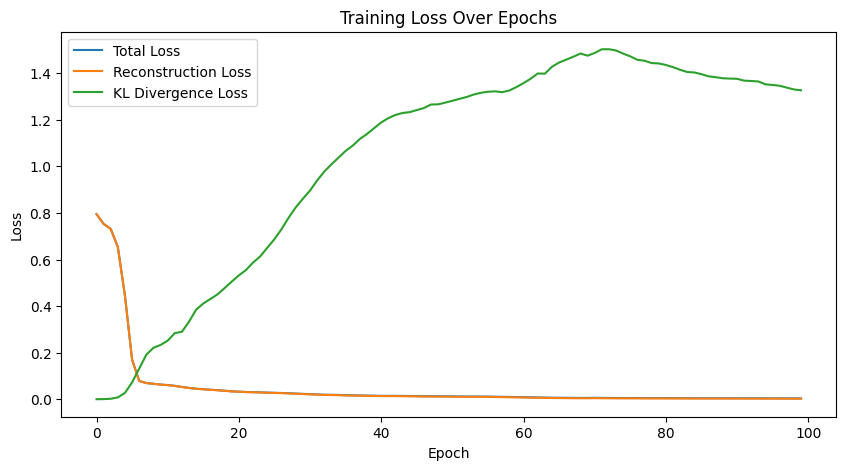

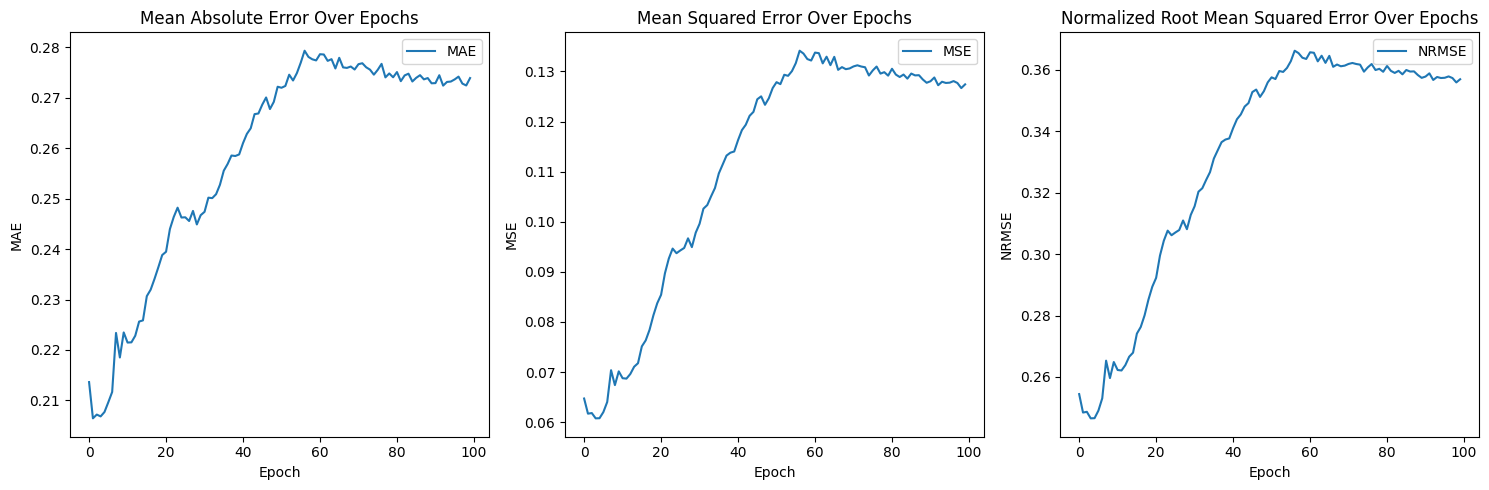

In [5]:
# Cell 4 (modified)
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        total_loss = reconstruction_loss + total_kl_loss
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, reconstruction_loss, kl_loss

batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices(combined_data).shuffle(10000).batch(batch_size)

epochs = 100
early_stopping_patience = 1000
min_delta = 0.0001
best_loss = float('inf')
patience_counter = 0

total_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
mae_history = []
mse_history = []
nrmse_history = []

for epoch in range(epochs):
    total_loss = 0
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = len(train_dataset)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for batch in train_dataset:
            total_loss_batch, reconstruction_loss, kl_loss = train_step(vae, batch, optimizer)
            total_loss += total_loss_batch
            reconstruction_loss_sum += reconstruction_loss
            kl_loss_sum += kl_loss
            pbar.update(1)
            pbar.set_postfix({'Total Loss': float(total_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    avg_total_loss = total_loss / num_batches
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    total_loss_history.append(avg_total_loss)
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate MAE, MSE, NRMSE
    augmented_data = vae.decode(tf.random.normal(shape=(combined_data.shape[0], latent_dim))).numpy()
    mae = mean_absolute_error(combined_data[:, :2], augmented_data[:, :2])
    mse = mean_squared_error(combined_data[:, :2], augmented_data[:, :2])
    rmse = np.sqrt(mse)
    nrmse = rmse / (combined_data[:, :2].max() - combined_data[:, :2].min())

    mae_history.append(mae)
    mse_history.append(mse)
    nrmse_history.append(nrmse)

    print(f"Epoch {epoch+1}: Total Loss = {avg_total_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"MAE = {mae:.6f}, MSE = {mse:.6f}, NRMSE = {nrmse:.6f}")

    if avg_total_loss < best_loss - min_delta:
        best_loss = avg_total_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Final output of metrics
print(f"Final MAE: {mae_history[-1]:.6f}")
print(f"Final MSE: {mse_history[-1]:.6f}")
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(total_loss_history, label='Total Loss')
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot MAE, MSE, and NRMSE history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(mae_history, label='MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(mse_history, label='MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Mean Squared Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

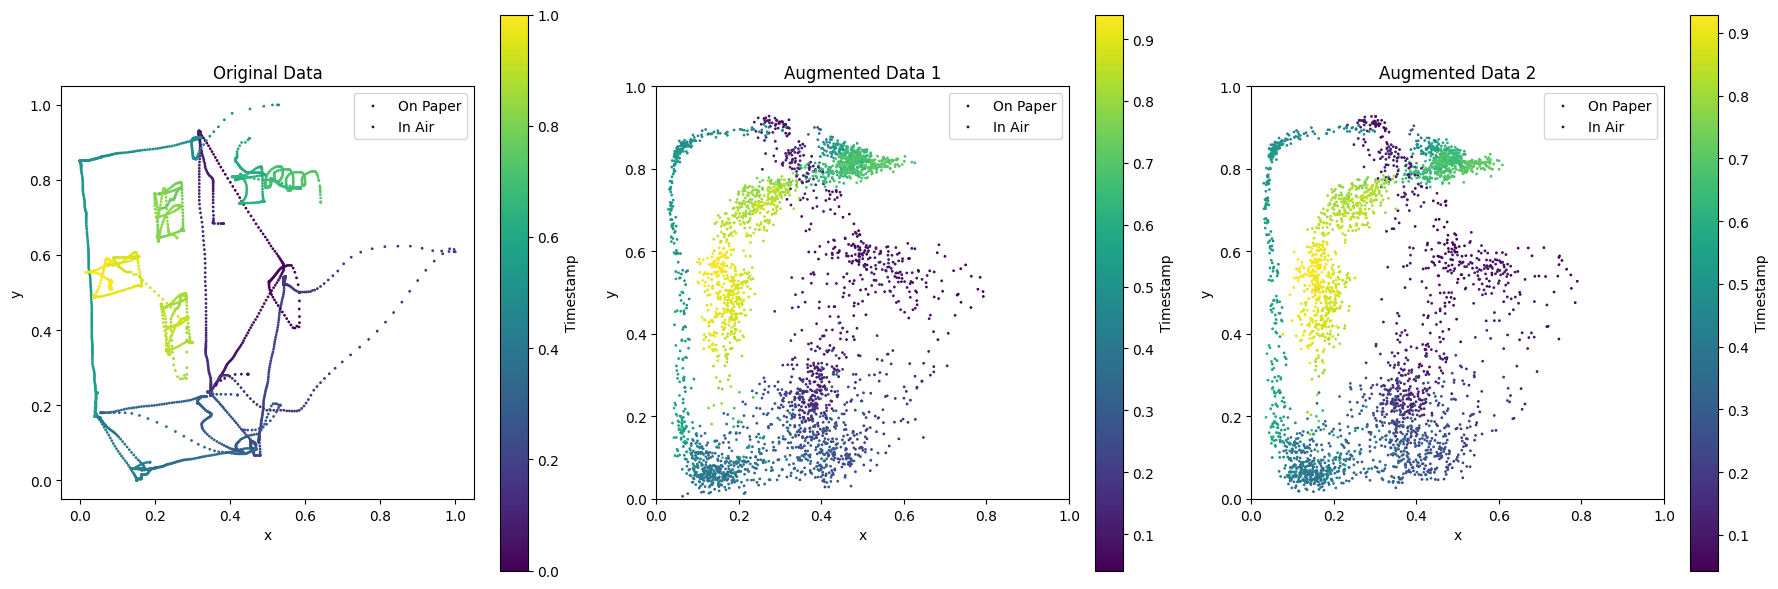

In [6]:
# Cell 5
def generate_augmented_data(model, num_augmented_files, avg_data_points, variability=0.1):
    augmented_datasets = []
    
    for _ in range(num_augmented_files):
        mean, logvar = model.encode(tf.convert_to_tensor(combined_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar)
        augmented_data = model.decode(z).numpy()

        num_points = int(avg_data_points * (1 + variability * (random.random() - 0.5) * 2))
        
        if num_points < augmented_data.shape[0]:
            augmented_data = augmented_data[:num_points]
        else:
            padding = np.zeros((num_points - augmented_data.shape[0], augmented_data.shape[1]))
            augmented_data = np.vstack([augmented_data, padding])

        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Sort by timestamp
        augmented_data = augmented_data[augmented_data[:, 2].argsort()]
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

def visualize_data(original_data, augmented_datasets):
    num_augmented_files = len(augmented_datasets)
    fig, axs = plt.subplots(1, num_augmented_files + 1, figsize=(6*(num_augmented_files + 1), 6))
    
    original_on_paper = original_data[original_data[:, 3] == 1]
    original_in_air = original_data[original_data[:, 3] == 0]
    sc = axs[0].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c=original_on_paper[:, 2], cmap='viridis', s=1, label='On Paper')
    axs[0].scatter(original_in_air[:, 0], original_in_air[:, 1], c=original_in_air[:, 2], cmap='viridis', s=1, label='In Air')
    axs[0].set_title('Original Data')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].set_aspect('equal')
    axs[0].legend()
    fig.colorbar(sc, ax=axs[0], label='Timestamp')

    x_min, x_max = original_data[:, 0].min(), original_data[:, 0].max()
    y_min, y_max = original_data[:, 1].min(), original_data[:, 1].max()

    for i, augmented_data in enumerate(augmented_datasets):
        augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
        augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
        sc = axs[i+1].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c=augmented_on_paper[:, 2], cmap='viridis', s=1, label='On Paper')
        axs[i+1].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c=augmented_in_air[:, 2], cmap='viridis', s=1, label='In Air')
        axs[i+1].set_title(f'Augmented Data {i+1}')
        axs[i+1].set_xlabel('x')
        axs[i+1].set_ylabel('y')
        axs[i+1].set_aspect('equal')
        axs[i+1].set_xlim(x_min, x_max)
        axs[i+1].set_ylim(y_min, y_max)
        axs[i+1].legend()
        fig.colorbar(sc, ax=axs[i+1], label='Timestamp')

    plt.tight_layout()
    plt.show()

# Generate and visualize augmented data
num_augmented_files = 2
augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points)
visualize_data(combined_data, augmented_datasets)

In [7]:
# Cell 6
# Updated function for downloading augmented data
def download_augmented_data(augmented_datasets, scalers, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, scaler) in enumerate(zip(augmented_datasets, scalers)):
        augmented_data_original_scale = np.column_stack((
            scaler.inverse_transform(augmented_data[:, :3]),  # Inverse scale x, y, timestamp
            augmented_data[:, 3]  # Keep pen_status unchanged
        ))
        # # Round coordinates and ensure pen_status is binary
        # augmented_data_original_scale[:, :2] = np.round(augmented_data_original_scale[:, :2])
        # augmented_data_original_scale[:, 2] = np.round(augmented_data_original_scale[:, 2]).astype(int)
        
        # Save each augmented dataset to a CSV file
        filename = os.path.join(directory, f'augmented_data_{i+1}.csv')
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'timestamp', 'pen_status']).to_csv(filename, index=False)
        print(f"Saved {filename}")

# Call the updated function with your augmented datasets
download_augmented_data(augmented_datasets, scalers[:len(augmented_datasets)])

Saved augmented_data\augmented_data_1.csv
